# Construct Inception V4 Model

In [25]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import scipy
import time

import tensorflow as tf

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Embedding, Flatten
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras import optimizers
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

from keras.models import Model
from keras.layers import concatenate, Input
from keras.layers import BatchNormalization
from keras import regularizers
from keras import initializers

import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,precision_score,recall_score, classification_report

from keras.utils.data_utils import get_file

In [26]:
WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [27]:
def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


In [28]:
def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

In [29]:
def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x

In [30]:
def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

In [31]:
def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x

In [32]:
def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

In [33]:
def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th) - NWHC (tf) or NCWH (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # Reduction-A block
    net = block_reduction_a(net)

    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # Reduction-B block
    net = block_reduction_b(net)

    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net

In [34]:
'''
Creates the inception v4 network
Args:
  num_classes: number of classes
  dropout_keep_prob: float, the fraction to keep before final layer.

Returns: 
  logits: the logits outputs of the model.
'''
def inception_v4(num_classes, dropout_keep_prob, weights, include_top):

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th) - NWHC (tf) or NCWH (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))

    # Make inception base
    x = inception_v4_base(inputs)

    # Final pooling and prediction
    if include_top:
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model

In [35]:
def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=True):
    return inception_v4(num_classes, dropout_prob, weights, include_top)

In [64]:
base_model = create_model(weights='imagenet', include_top=False) # , 
base_model.summary()

Model: "inception_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_596 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_596 (BatchN (None, 149, 149, 32) 96          conv2d_596[0][0]                 
__________________________________________________________________________________________________
activation_596 (Activation)     (None, 149, 149, 32) 0           batch_normalization_596[0][0]    
_______________________________________________________________________________________

# Mount Covid Data and view samples

In [54]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = '/content/drive/MyDrive/IISc'


train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_covid_dir = os.path.join(train_dir, 'Covid')
train_normal_dir = os.path.join(train_dir, 'Non Covid')

test_covid_dir = os.path.join(test_dir, 'Covid')
test_normal_dir = os.path.join(test_dir, 'Non Covid')


Mounted at /content/drive


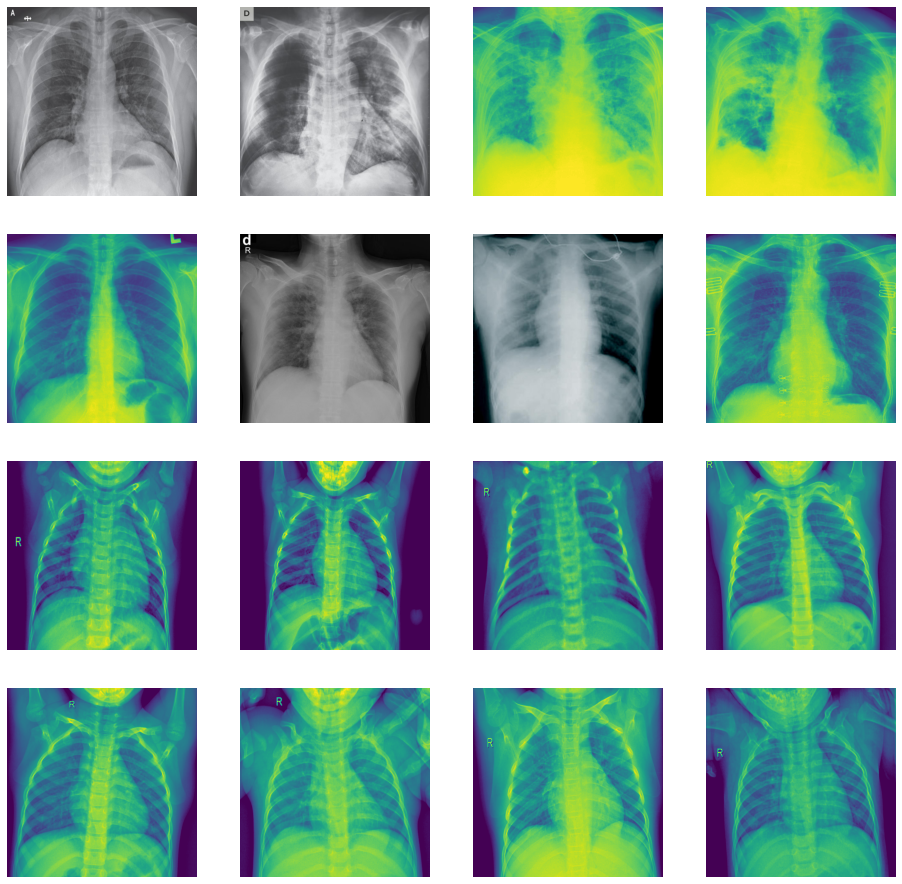

In [55]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def verify_data():
  nrows = 4
  ncols = 4

  fig = plt.gcf()
  fig.set_size_inches(ncols*4, nrows*4)
  pic_index = 100
  train_covid_fnames = os.listdir( train_covid_dir )
  train_normal_fnames = os.listdir( train_normal_dir )


  next_covid_pic = [os.path.join(train_covid_dir, fname) 
                for fname in train_covid_fnames[ pic_index-8:pic_index] 
               ]

  next_normal_pic = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

  for i, img_path in enumerate(next_covid_pic+next_normal_pic):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

verify_data()

In [56]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 50, 
                                                    class_mode = 'binary', 
                                                    target_size = (299, 299), 
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,  
                                                  batch_size = 10, 
                                                  class_mode = 'binary', 
                                                  target_size = (299, 299))


Found 238 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


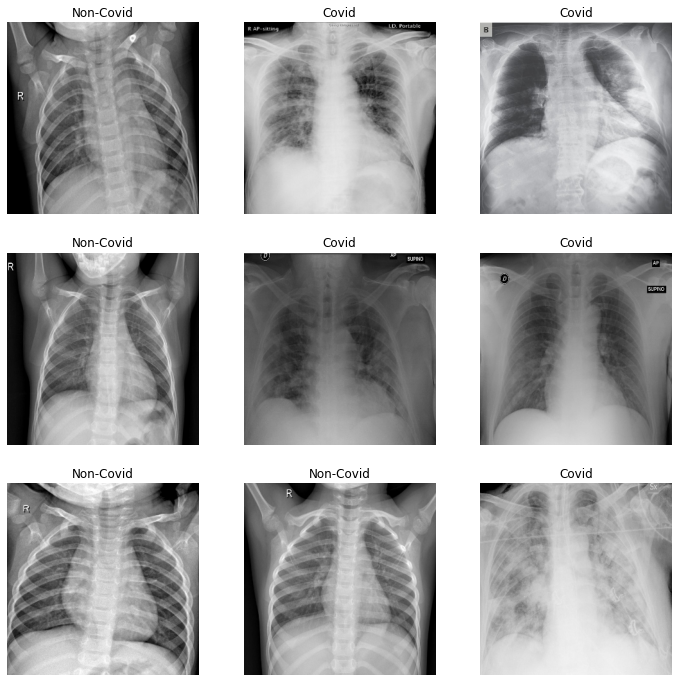

In [57]:
x_batch, y_batch = next(train_generator)
nrows = 3
ncols = 3
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i in range (0,9):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    image = x_batch[i]
    plt.imshow(image)
    title = 'Non-Covid'
    if y_batch[i] == 0:
        title = 'Covid'
    plt.title(title)
plt.show()

# Modify Inception V4 Output layer for binary classification

In [65]:
# Make layers non-trainable as we are using pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

In [66]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True), 
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Train Model

In [72]:
callback_list = []
train_name = str(int(time.time()))
initial_epoch = 0
if not os.path.exists('model_res/' + train_name):
    os.makedirs('model_res/' + train_name)
model_path="model_res/" + train_name +"/model.hdf5"

callback_list.append(EarlyStopping(monitor='val_loss', patience=1000))
callback_list.append(TensorBoard(log_dir='./logs/res/' + train_name))
callback_list.append(ModelCheckpoint(model_path, period=1, monitor='val_loss', mode='min'))

inceptionhist = model.fit(train_generator, 
                              validation_data = test_generator, 
                              shuffle=True,
                              steps_per_epoch=4,
                              validation_steps=2,
                              epochs = 10,
                              initial_epoch=initial_epoch,
                              verbose=1,
                              callbacks=callback_list)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Epoch 1/10
4/4 [==============================] - 102s 26s/step - loss: 3.1731 - acc: 0.6400 - val_loss: 3.1633 - val_acc: 0.8000
Epoch 2/10
4/4 [==============================] - 92s 23s/step - loss: 3.1618 - acc: 0.6223 - val_loss: 3.2651 - val_acc: 0.3500
Epoch 3/10
4/4 [==============================] - 93s 24s/step - loss: 3.1452 - acc: 0.7128 - val_loss: 3.1580 - val_acc: 0.8000
Epoch 4/10
4/4 [==============================] - 95s 24s/step - loss: 3.1429 - acc: 0.6915 - val_loss: 3.1962 - val_acc: 0.5000
Epoch 5/10
4/4 [==============================] - 93s 24s/step - loss: 3.1223 - acc: 0.7128 - val_loss: 3.1166 - val_acc: 0.8000
Epoch 6/10
4/4 [==============================] - 93s 24s/step - loss: 3.1088 - acc: 0.7606 - val_loss: 3.1722 - val_acc: 0.6000
Epoch 7/10
4/4 [==============================] - 95s 26s/step - loss: 3.0860 - acc: 0.7553 - val_loss: 3.1463 - val_acc: 0.7000
Epoch 8/10
4/4 [========

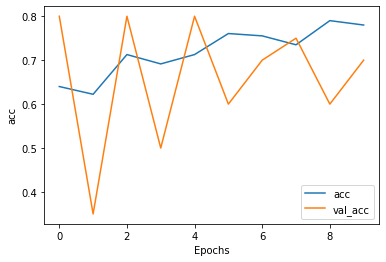

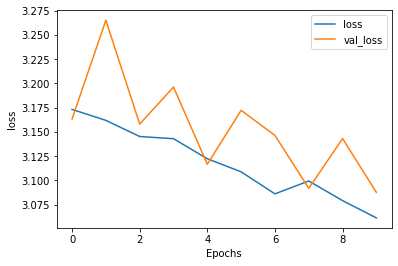

In [73]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(inceptionhist,'acc')
plot_graphs(inceptionhist,'loss')

# Evaluate Results

In [74]:
#Accuracy and Loss of Validation Data
loss, accuracy = model.evaluate_generator(test_generator,steps=4,verbose=1)
print("Validation Accuracy: ",accuracy)
print("Validation Loss: ",loss)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


4/4 [==============================] - 18s 4s/step - loss: 3.0895 - acc: 0.7692
Validation Accuracy:  0.7692307829856873
Validation Loss:  3.08949613571167


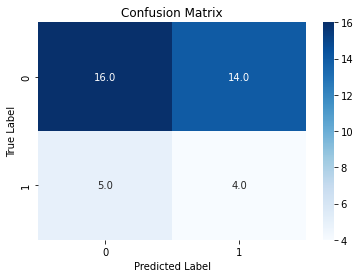

In [78]:
import seaborn as sns

#Getting Predicted Value
Y_pred = model.predict(test_generator,steps=4)
y_pred = np.where(Y_pred>0.5, 1, 0) #np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))
confusion = confusion_matrix(test_generator.classes, y_pred)

sns.heatmap(confusion, annot=True,cmap="Blues",fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display Misclassified Images

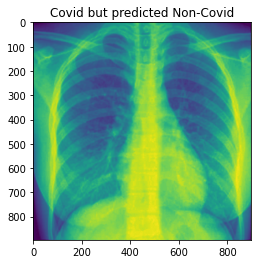

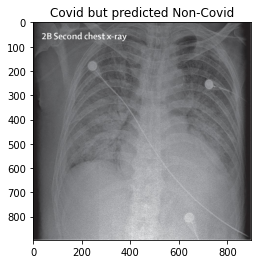

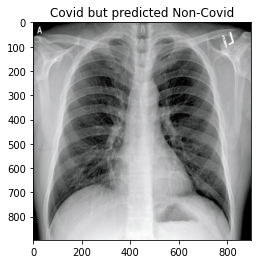

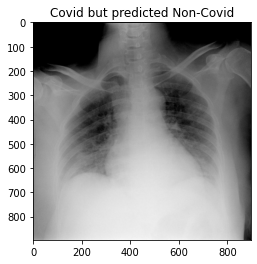

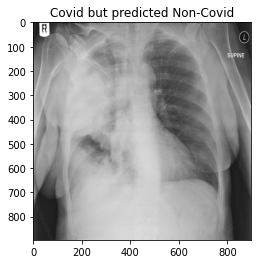

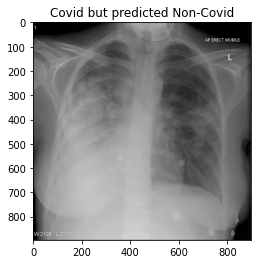

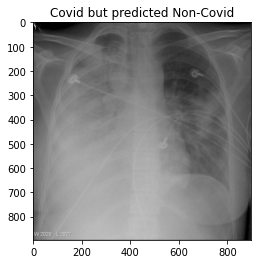

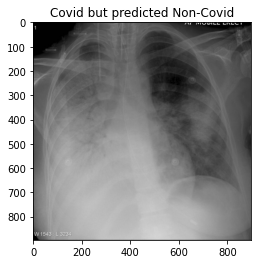

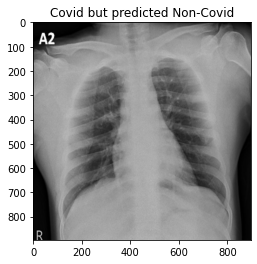

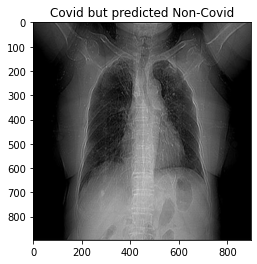

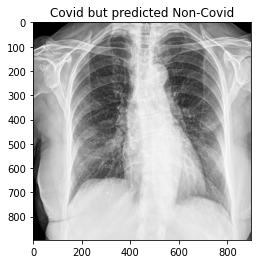

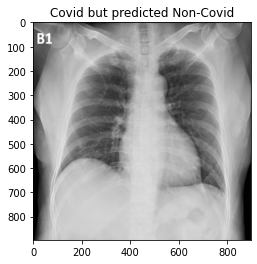

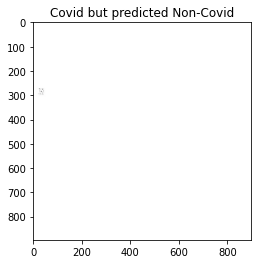

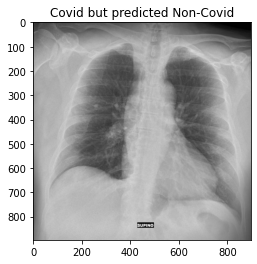

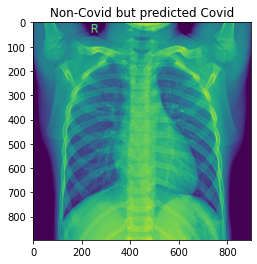

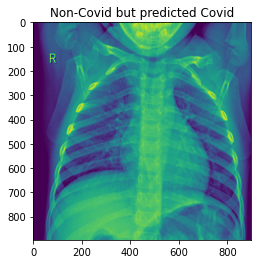

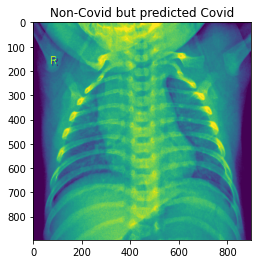

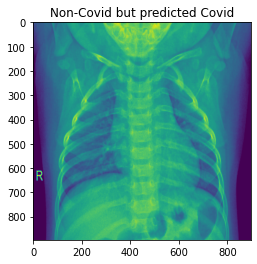

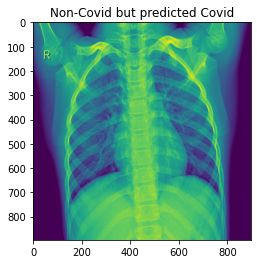

In [80]:
test_covid_fnames = os.listdir( test_covid_dir )
test_normal_fnames = os.listdir( test_normal_dir )

next_covid_pic = sorted([os.path.join(test_covid_dir, fname) 
                for fname in test_covid_fnames])

next_normal_pic = sorted([os.path.join(test_normal_dir, fname) 
                for fname in test_normal_fnames])

test_pics = next_covid_pic + next_normal_pic

for i in range(0, 39):
    if test_generator.classes[i] != y_pred[i]:

      if(y_pred[i] == 1 and test_generator.classes[i] == 0):
        title = "Covid but predicted Non-Covid"
      
      if(y_pred[i] == 0 and test_generator.classes[i] == 1):
        title = 'Non-Covid but predicted Covid'

      sp.axis('Off') 
      img = mpimg.imread(test_pics[i])

      plt.imshow(img)
      plt.title(title)
      plt.show()

# Conclusions

- ResNet-16 is superior compared to InceptionV4 for binary classification and it requires an order of magnitude less training time and converges faster for achieving similar accuracy level

- Model complexity must match the task

  - Paramter size for Inception V4
Total params: 41,174,400
Trainable params: 41,111,232
Non-trainable params: 63,168

  - Parameter size for Resnet-16
Total params: 100,877,969
Trainable params: 100,875,147
Non-trainable params: 2,822


- Due to class imbalance present in the test set the models favour prediction of certain classes - these can be solved by setting appropriate class weights for model evaluation

- Inception V4 requires precise hyper-parameter tuning and does not converge with default learning rate of 0.01

- Hyper-parameter search needs to be more systematized to avoid wasting GPU resources.
